In [412]:
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import numpy as np
from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

import matplotlib as mpl
import matplotlib.cm as cm

# Load data

In [2]:
df = pd.read_csv("stackoverflow_survey_single_response.csv")
questions = pd.read_csv("stackoverflow_survey_questions.csv")
label_dict = pd.read_csv("qname_levels_single_response_crosswalk.csv")

## Clean

In [3]:
# map labels to questions
columns = ["age", "ai_sent", "ai_select", "ai_acc", "ai_complex", "ai_threat"] 

for column in columns:
    _filter = label_dict["qname"]==column
    map = dict(zip(label_dict[_filter]["level"],  label_dict[_filter]["label"]))
    df[column + "_l"] = df[column].map(map)

In [4]:
#create column based on binned values and add labels
_bins = [0,5,10,15,20,25,30, 100]
labels = [str(i+1)+"-"+str(i+5) for i in _bins[0:-2]] + [">30"]
df['years_code_bin'] = pd.cut(df['years_code'], bins=_bins, labels=labels)
df['years_code_pro_bin'] = pd.cut(df['years_code_pro'], bins=_bins, labels=labels)

### Checks

In [114]:
df[["age","age_l"]].value_counts().sort_index()

age  age_l             
1    18-24 years old       14098
2    25-34 years old       23911
3    35-44 years old       14942
4    45-54 years old        6249
5    55-64 years old        2575
6    65 years or older       772
7    Prefer not to say       322
8    Under 18 years old     2568
Name: count, dtype: int64

In [110]:
# check responses
pivot = df.groupby(["age_l", "years_code_bin"], observed=True)["response_id"].count().unstack()
pivot

years_code_bin,1-5,6-10,11-15,16-20,21-25,26-30,>30
age_l,,,,,,,
18-24 years old,5967.0,5500.0,648.0,30.0,3.0,2.0,3.0
25-34 years old,3166.0,8976.0,6831.0,2393.0,285.0,25.0,8.0
35-44 years old,798.0,1661.0,2466.0,3843.0,3197.0,1538.0,404.0
45-54 years old,186.0,251.0,276.0,475.0,873.0,1497.0,2374.0
55-64 years old,64.0,66.0,44.0,81.0,146.0,261.0,1806.0
65 years or older,23.0,16.0,11.0,25.0,21.0,42.0,588.0
Prefer not to say,86.0,40.0,13.0,16.0,14.0,16.0,48.0
Under 18 years old,1595.0,580.0,18.0,1.0,NaN,NaN,3.0


## Data viz

In [275]:
# % of developers who think AI is a threat by age + years coding

# create filter to remove values where sample size < 100
df.loc[(df["age_l"] =="Under 18 years old") & (df["years_code"]>10), "code_filter"] = 1
df.loc[(df["age_l"] =="18-24 years old") & (df["years_code"]>10), "code_filter"] = 1
df.loc[(df["age_l"] =="25-34 years old") & (df["years_code"]>20), "code_filter"] = 1
df.loc[(df["age_l"] =="35-44 years old") & (df["years_code"]<6), "code_filter"] = 1
df.loc[(df["age_l"] =="35-44 years old") & (df["years_code"]>25), "code_filter"] = 1
df.loc[(df["age_l"] =="45-54 years old") & (df["years_code"]<21), "code_filter"] = 1
df.loc[(df["age_l"] =="55-64 years old") & (df["years_code"]<21), "code_filter"] = 1

# get data by age + years coding
_filter = ((df["code_filter"] != 1) & (~df["age_l"].isin(["65 years or older", "Prefer not to say", "55-64 years old"])))
pivot_scatter = df[_filter].groupby(["age", "years_code_bin"], observed=True)["ai_threat_l"].value_counts(normalize=True).unstack() *100
pivot_scatter = pivot_scatter["Yes"].to_frame().reset_index()
pivot_scatter["age"] = pivot_scatter["age"].replace(8,0)
pivot_scatter

,age,years_code_bin,Yes
0,1,1-5,14.836547
1,1,6-10,10.247892
2,2,1-5,14.052160
3,2,6-10,12.178932
4,2,11-15,10.173597
5,2,16-20,8.487085
6,3,6-10,14.285714
7,3,11-15,13.539967
8,3,16-20,12.295380
9,3,21-25,10.087116


In [174]:
# % of developers who think AI is a threat by age
_filter = ((~df["age_l"].isin(["65 years or older", "Prefer not to say",])))
pivot_bary = df[_filter].groupby(["age", "age_l"], observed=True)["ai_threat_l"].value_counts(normalize=True).unstack() *100
pivot_bary = pivot_bary["Yes"].to_frame().reset_index()
pivot_bary["age"] = pivot_bary["age"].replace(8,0)
pivot_bary = pivot_bary.sort_values(by="age")
pivot_bary

,age,age_l,Yes
5,0,Under 18 years old,14.473684
0,1,18-24 years old,13.026820
1,2,25-34 years old,11.574761
2,3,35-44 years old,12.025378
3,4,45-54 years old,12.218045
4,5,55-64 years old,8.762887


In [125]:
# % of developers who think AI is a threat by years coding
_filter = ((~df["age_l"].isin(["65 years or older", "Prefer not to say",])))
pivot_barx = df[_filter].groupby(["years_code_bin"], observed=True)["ai_threat_l"].value_counts(normalize=True).unstack()*100
pivot_barx = pivot_barx["Yes"].to_frame().reset_index()
pivot_barx

,years_code_bin,Yes
0,1-5,14.449689
1,6-10,11.822390
2,11-15,11.000672
3,16-20,11.071726
4,21-25,11.265782
5,26-30,9.707865
6,>30,9.607293


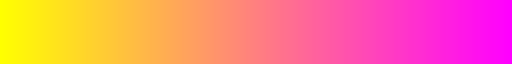

In [237]:
# create colormap
cmap = mpl.colormaps['spring_r']
norm = mpl.colors.Normalize(vmin=8, vmax=17)
m = cm.ScalarMappable(norm=norm, cmap=cmap)
cmap

In [400]:
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\UbuntuMono-B.ttf')
legend_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Roboto-Regular.ttf')
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\UbuntuMono-R.ttf')

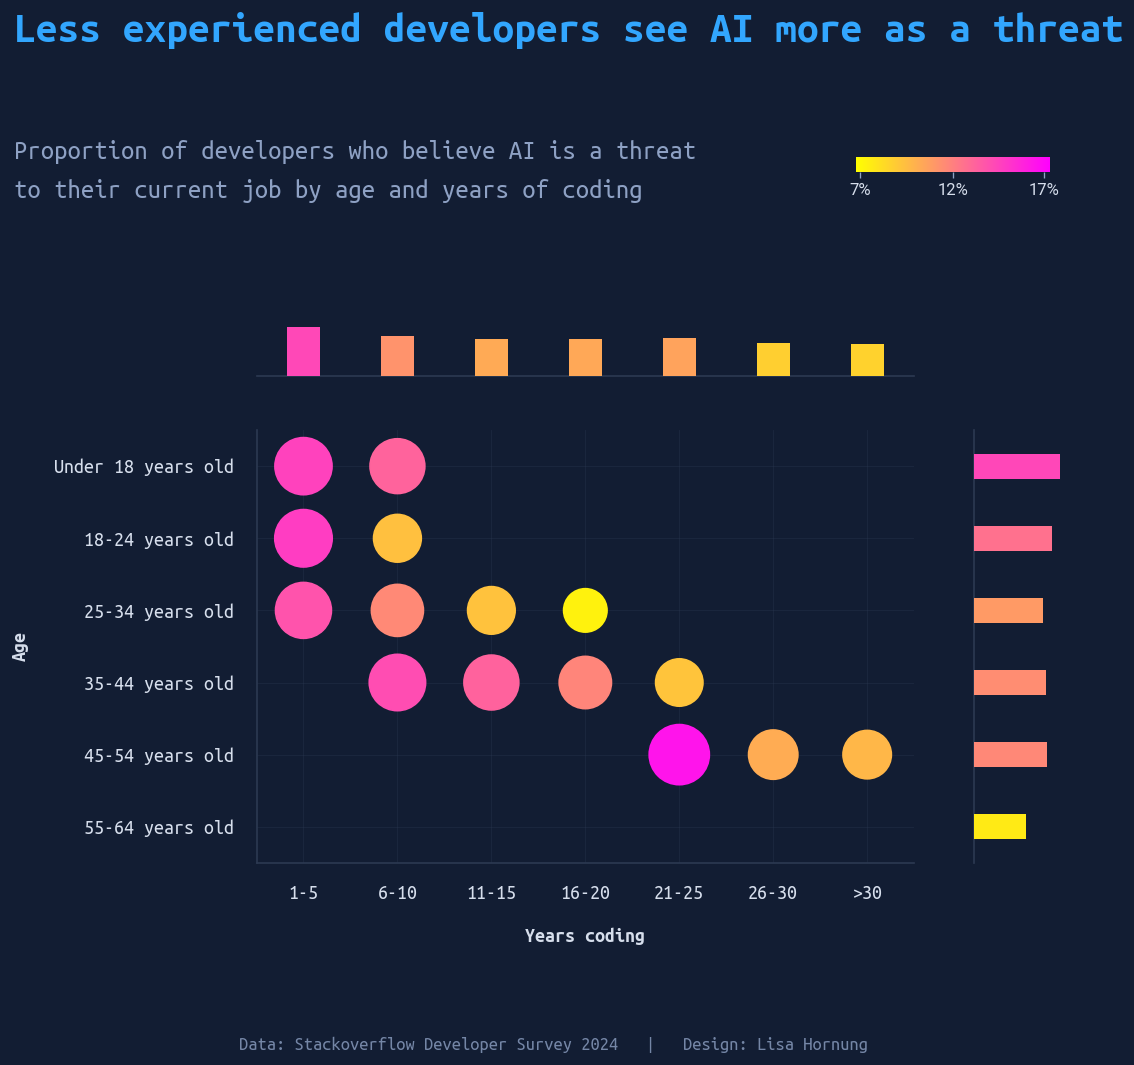

In [410]:
# Chart setup ------------
fig = plt.figure(figsize=(9,6), dpi=120)
gs = GridSpec(5, 5)
ax_scatter = fig.add_subplot(gs[1:5, 0:4])
ax_barx = fig.add_subplot(gs[0,0:4])
ax_bary = fig.add_subplot(gs[1:5, 4])
fig.subplots_adjust(wspace=0.5, hspace=0.8)

cols = {"bg": "#121D33", "text": "#D6DEEC","title": "#32A6FE", "grid": "#2C3952", "subtitle": "#8EA1C4"}
fig.set_facecolor(cols["bg"])

# plot data --------------------
ax_scatter.scatter(pivot_scatter["years_code_bin"],pivot_scatter["age"], s=[i*80 for i in pivot_scatter["Yes"]],
                   c=pivot_scatter["Yes"], cmap=cmap,clip_on=False, vmin=8, vmax=17, zorder=3)
ax_bary.barh(pivot_bary["age"], pivot_bary["Yes"], height=0.35, color=m.to_rgba(pivot_bary["Yes"]), zorder=3)
ax_barx.bar(pivot_barx["years_code_bin"],pivot_barx["Yes"], width=0.35, color=m.to_rgba(pivot_barx["Yes"]) , zorder=3)

# format axes --------------------
for ax in [ax_scatter, ax_bary]:
    ax.set_ylim(ymin=-0.5, ymax=5.5)
    ax.invert_yaxis()
    ax.set_facecolor(cols["bg"])
for ax in [ax_scatter, ax_barx]:
    ax.set_xlim(xmin=-0.5, xmax=6.5)
    ax.set_facecolor(cols["bg"])
ax_bary.set_xlim(xmin=0,xmax=20)
ax_barx.set_ylim(ymin=0,ymax=20)

#spines
for pos in ["top", "right"]:
    ax_barx.spines[pos].set_visible(False)
    ax_bary.spines[pos].set_visible(False)
    ax_scatter.spines[pos].set_visible(False)
ax_bary.spines["bottom"].set_visible(False)
ax_barx.spines["left"].set_visible(False)
ax_barx.spines["bottom"].set(color=cols["grid"], linewidth=1)
ax_bary.spines["left"].set(color=cols["grid"], linewidth=1)
ax_scatter.spines["left"].set(color=cols["grid"], linewidth=1)
ax_scatter.spines["bottom"].set(color=cols["grid"], linewidth=1)


# ticks and grids
ax_barx.tick_params(axis='both', bottom=False, left=False, labelbottom=False,pad=10, labelleft=False, )
ax_bary.tick_params(axis='both', left=False,bottom=False, labelleft=False,pad=10,  labelbottom=False, )
#ax_barx.grid(visible=True, axis='y', zorder=2, color='#333333', linewidth=0.75, alpha=0.2)

ax_scatter.grid(visible=True, axis='both', zorder=2, color=cols["grid"], linewidth=0.5, alpha=0.4)
ax_scatter.tick_params(axis='both', left=False, bottom=False,pad=10 )
ax_scatter.set_yticks(np.arange(0,6,1), pivot_bary["age_l"], fontproperties=label_font, fontsize=12, color=cols["text"])
ax_scatter.set_xticks(ax_scatter.get_xticks(), ax_scatter.get_xticklabels(), fontproperties=label_font, fontsize=12, color=cols["text"])
ax_scatter.set_xlabel("Years coding", labelpad=15, fontproperties=title_font, fontsize=12, color=cols["text"])
ax_scatter.set_ylabel("Age", labelpad=15, fontproperties=title_font, fontsize=12, color=cols["text"])

# colorbar ------------------
cbaxes = fig.add_axes([0.68, 1.07, 0.18, 0.02]) #axes to hold colorbar
cmappable = cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False, ticks=[0.02, 0.5,0.97])
cb.set_ticks(ticks=[0.02, 0.5,0.97],labels=["7%", "12%", "17%"] , color=cols["text"], fontproperties=legend_font)
cb.outline.set_visible(False)
cbaxes.tick_params(color=cols["subtitle"])

# title and footer --------------
plt.figtext(-0.1,1.25, "Less experienced developers see AI more as a threat", fontproperties = title_font, fontsize=26, ha="left", color=cols["title"])
plt.figtext(-0.1,1.07, "Proportion of developers who believe AI is a threat\nto their current job by age and years of coding ", fontproperties = label_font, 
            fontsize=16, ha="left",color=cols["subtitle"] , va="center", linespacing=1.8)
plt.figtext(0.4,-0.15, "Data: Stackoverflow Developer Survey 2024   |   Design: Lisa Hornung", fontsize=11,  ha="center",fontproperties = label_font,  alpha=0.8, color=cols["subtitle"])

# save output ----------
plt.savefig("developer-survey-ai-threat-by-age-coding.png", bbox_inches='tight', dpi=120, pad_inches=1)
plt.savefig("developer-survey-ai-threat-by-age-coding.svg", )


plt.show()

## Explore

In [ ]:
## Test pyfonts
from pyfonts import load_font
import matplotlib.pyplot as plt

font = load_font(
  "https://github.com/JulietaUla/Montserrat/raw/master/fonts/ttf/MontserratAlternates-Medium.ttf?raw=true"
)

fig, ax = plt.subplots(figsize=(4, 4), dpi=120)
ax.text(
    x=0.5,
    y=0.5,
    s=f"Amaranth font\nwith PyFonts!!!",
    font=font,
    fontweight=800,
    fontsize=30,
    ha="center",
)
plt.show()

In [4]:
df.head()

,response_id,main_branch,age,remote_work,ed_level,years_code,years_code_pro,dev_type,org_size,purchase_influence,...,ai_select,ai_sent,ai_acc,ai_complex,ai_threat,survey_length,survey_ease,converted_comp_yearly,r_used,r_want_to_use
0,1,1,8,3.0,4.0,NaN,NaN,NaN,NaN,NaN,...,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,3,3.0,2.0,20.0,17.0,16.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,3,1,4,3.0,3.0,37.0,27.0,10.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN,0.0,0.0
3,4,2,1,NaN,7.0,4.0,NaN,16.0,NaN,NaN,...,3.0,5.0,5.0,1.0,2.0,2.0,2.0,NaN,0.0,0.0
4,5,1,1,NaN,6.0,9.0,NaN,16.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,3.0,2.0,NaN,0.0,0.0


In [47]:
df['years_code_bin'].value_counts()

years_code_bin
6-10     17090
1-5      11885
11-15    10307
16-20     6864
>30       5234
21-25     4539
26-30     3381
Name: count, dtype: int64

In [127]:
df.groupby("age_l")["ai_select_l"].value_counts(normalize=True).unstack() *100

ai_select_l,"No, and I don't plan to","No, but I plan to soon",Yes
age_l,,,
18-24 years old,20.848694,8.753628,70.397678
25-34 years old,21.466606,12.964801,65.568592
35-44 years old,25.913339,16.142736,57.943925
45-54 years old,27.990670,19.393535,52.615795
55-64 years old,36.981891,22.132797,40.885312
65 years or older,47.311828,20.430108,32.258065
Prefer not to say,41.877256,13.718412,44.404332
Under 18 years old,29.374472,9.932375,60.693153


In [ ]:
df.groupby("age_l")["ai_select_l"].value_counts(normalize=True).unstack() *100

In [241]:
df.columns

Index(['response_id', 'main_branch', 'age', 'remote_work', 'ed_level',
       'years_code', 'years_code_pro', 'dev_type', 'org_size',
       'purchase_influence', 'buildvs_buy', 'country', 'currency',
       'comp_total', 'so_visit_freq', 'so_account', 'so_part_freq', 'so_comm',
       'ai_select', 'ai_sent', 'ai_acc', 'ai_complex', 'ai_threat',
       'survey_length', 'survey_ease', 'converted_comp_yearly', 'r_used',
       'r_want_to_use', 'age_l', 'ai_sent_l', 'ai_select_l', 'ai_acc_l',
       'ai_complex_l', 'ai_threat_l', 'years_code_bin', 'years_code_pro_bin',
       'code_filter'],
      dtype='object')

In [129]:
_filter = ((df["code_filter"] != 1) & (~df["age_l"].isin(["65 years or older", "Prefer not to say", "Under 18 years old"])) & (df["years_code"]>0))
df[_filter].groupby("age_l")["ai_threat_l"].value_counts(normalize=True).unstack() *100

ai_threat_l,I'm not sure,No,Yes
age_l,,,
18-24 years old,23.222749,64.168412,12.608839
25-34 years old,18.844237,69.702751,11.453012
35-44 years old,19.118828,69.048575,11.832597
45-54 years old,17.557803,70.399807,12.042389
55-64 years old,13.430657,78.029197,8.540146


In [126]:
# % of developers who used AI by age + years coding professionally
_filter = ((df["code_pro_filter"] != 1) & (~df["age_l"].isin(["65 years or older", "Prefer not to say", "Under 18 years old"])))
pivot = df[_filter].groupby(["age_l", "years_code_pro_bin"], observed=True)["ai_select_l"].value_counts(normalize=True).unstack()*100
pivot["Yes"].unstack()

years_code_pro_bin,1-5,6-10,11-15,16-20,21-25,26-30,>30
age_l,,,,,,,
18-24 years old,72.748092,66.304348,NaN,NaN,NaN,NaN,NaN
25-34 years old,67.874644,62.937866,62.145749,53.521127,NaN,NaN,NaN
35-44 years old,68.434134,60.278746,56.364062,53.715815,56.898396,57.843137,NaN
45-54 years old,64.186047,58.881579,48.741419,55.157895,51.862803,51.117520,50.953678
55-64 years old,NaN,NaN,41.176471,48.305085,42.600897,41.561181,39.638009


In [131]:
# % of developers who used AI by age + years coding professionally
_filter = ((df["code_filter"] != 1) & (~df["age_l"].isin(["65 years or older", "Prefer not to say", "Under 18 years old"])))
pivot = df[_filter].groupby(["age_l", "years_code_bin"], observed=True)["ai_threat_l"].value_counts(normalize=True).unstack()*100
pivot["Yes"].unstack()

years_code_bin,1-5,6-10,11-15,16-20,21-25,26-30,>30
age_l,,,,,,,
18-24 years old,14.836547,10.247892,9.020619,NaN,NaN,NaN,NaN
25-34 years old,14.052160,12.178932,10.173597,8.487085,8.235294,NaN,NaN
35-44 years old,12.369598,14.285714,13.539967,12.295380,10.087116,8.510638,8.433735
45-54 years old,18.238994,10.891089,11.520737,12.427746,16.275430,10.941960,10.533160
55-64 years old,NaN,NaN,NaN,17.073171,9.375000,8.426966,8.151659


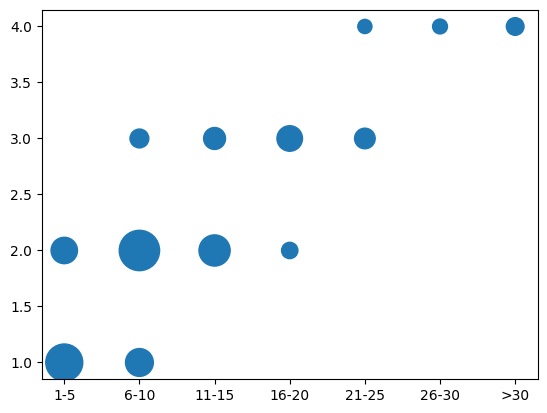

In [163]:
plt.scatter(pivot["years_code_bin"],pivot["age"], s=pivot["Yes"])

In [136]:

_filter = ((df["code_pro_filter"] != 1) & (~df["age_l"].isin(["65 years or older", "Prefer not to say", "Under 18 years old"])))
_filter = ((~df["age_l"].isin(["65 years or older", "Prefer not to say", "Under 18 years old"])))
pivot = df[_filter].groupby(["age_l", "years_code_pro_bin"], observed=True)["ai_threat_l"].value_counts(normalize=True).unstack()*100
pivot["Yes"].unstack()

years_code_pro_bin,1-5,6-10,11-15,16-20,21-25,26-30,>30
age_l,,,,,,,
18-24 years old,11.286940,7.894737,22.222222,40.000000,100.000000,NaN,NaN
25-34 years old,11.812158,11.104387,9.109449,11.000000,20.000000,100.000000,NaN
35-44 years old,12.160804,12.956964,12.549020,10.054691,7.926829,6.153846,55.555556
45-54 years old,12.209302,10.887097,12.580645,14.125874,12.329932,9.178228,11.904762
55-64 years old,8.108108,17.241379,6.521739,11.494253,9.489051,9.030100,7.208589


In [135]:
_filter = ((df["code_pro_filter"] != 1) & (~df["age_l"].isin(["65 years or older", "Prefer not to say", "Under 18 years old"])))
pivot = df[_filter].groupby(["age_l", "years_code_pro_bin"], observed=True)["ai_threat_l"].value_counts(normalize=False).unstack()
pivot["Yes"].unstack()

years_code_pro_bin,1-5,6-10,11-15,16-20,21-25,26-30,>30
age_l,,,,,,,
18-24 years old,592.0,21.0,NaN,NaN,NaN,NaN,NaN
25-34 years old,820.0,734.0,134.0,11.0,NaN,NaN,NaN
35-44 years old,121.0,280.0,384.0,239.0,52.0,4.0,NaN
45-54 years old,21.0,27.0,39.0,101.0,145.0,86.0,30.0
55-64 years old,NaN,NaN,2.0,10.0,13.0,27.0,47.0


<Axes: >

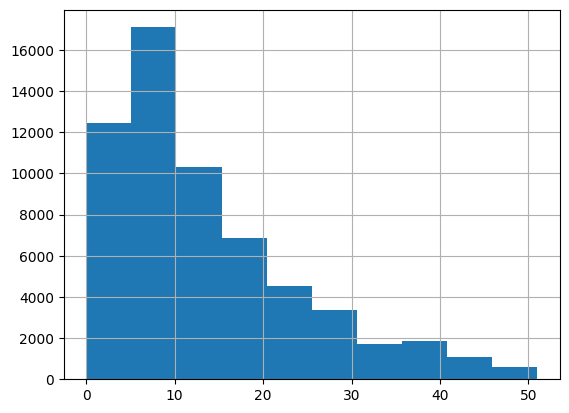

In [6]:
df["years_code"].hist()

In [5]:
df["age_l"].value_counts()

age_l
25-34 years old       23911
35-44 years old       14942
18-24 years old       14098
45-54 years old        6249
55-64 years old        2575
Under 18 years old     2568
65 years or older       772
Prefer not to say       322
Name: count, dtype: int64

In [49]:
df.groupby("age_l")["ai_threat_l"].value_counts(normalize=True).unstack() *100

ai_threat_l,I'm not sure,No,Yes
age_l,,,
18-24 years old,23.526975,63.446205,13.026820
25-34 years old,18.976672,69.448567,11.574761
35-44 years old,19.180088,68.794534,12.025378
45-54 years old,17.645677,70.136278,12.218045
55-64 years old,13.788660,77.448454,8.762887
65 years or older,12.403101,78.552972,9.043928
Prefer not to say,27.516779,55.033557,17.449664
Under 18 years old,24.436090,61.090226,14.473684


In [6]:
label_dict

,qname,level,label
0,main_branch,1,I am a developer by profession
1,main_branch,2,I am learning to code
2,main_branch,3,"I am not primarily a developer, but I write co..."
3,main_branch,4,I code primarily as a hobby
4,main_branch,5,"I used to be a developer by profession, but no..."
...,...,...,...
117,survey_length,2,Too long
118,survey_length,3,Too short
119,survey_ease,1,Difficult
120,survey_ease,2,Easy


In [5]:
questions

,qname,question
0,main_branch,Which of the following options best describes ...
1,age,What is your age?*
2,remote_work,Which best describes your current work situation?
3,ed_level,Which of the following best describes the high...
4,years_code,"Including any education, how many years have y..."
5,years_code_pro,"NOT including education, how many years have y..."
6,dev_type,Which of the following describes your current ...
7,org_size,Approximately how many people are employed by ...
8,purchase_influence,"What level of influence do you, personally, ha..."
9,buildvs_buy,When asked to provide a recommendation for sol...
